Кувалдин Антон  
М05-014в  
Домашнее задание 2. Spotter

In [1]:
!apt install sox

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrwb0 amd64 0.1.3-2.1 [45.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates/main a

### Baseline commands recognition (2-5 points)

We're now going to train a classifier to recognize voice. More specifically, we'll use the [Speech Commands Dataset] that contains around 30 different words with a few thousand voice records each.

In [17]:
import os
from IPython.display import display, Audio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import librosa
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm.notebook import tqdm
import joblib as jl
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls))]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

--2021-10-26 18:37:22--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.135.128, 2607:f8b0:400e:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.135.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   242MB/s    in 5.8s    

2021-10-26 18:37:28 (243 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [4]:
!sox --info speech_commands/bed/00176480_nohash_0.wav


Input File     : 'speech_commands/bed/00176480_nohash_0.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:01.00 = 16000 samples ~ 75 CDDA sectors
File Size      : 32.0k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [6]:
classes = ("left", "right", "up", "down", "stop")

def preprocess_sample(filepath, max_length=160):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))
spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  0%|          | 0/11834 [00:00<?, ?it/s]

In [7]:
print('Train before: {}'.format(X_train.shape))
print('Test before: {}'.format(X_test.shape))
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print('Train after: {}'.format(X_train.shape))
print('Test after: {}'.format(X_test.shape))

Train before: (8875, 160, 128)
Test before: (2959, 160, 128)
Train after: (8875, 1, 160, 128)
Test after: (2959, 1, 160, 128)


In [8]:
if torch.cuda.is_available:
  device = 'cuda'
else:
  device = 'cpu'

batch_size = 16

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [9]:
X_train.shape

(8875, 1, 160, 128)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(4)
        self.conv4 = nn.Conv2d(256, 256, 5)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 5)

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.softmax(x)
        return x


net = Net().to(device)

In [11]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        #print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    return float(num_correct)/float(num_samples)*100

In [12]:
import seaborn as sns
sns.set()
from IPython.display import clear_output

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

from IPython import display
from ipywidgets import Output

def plot_progress(losses, scores, disp):
  with disp:
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot([i*100 for i in range(len(losses))], losses)
    ax[1].plot([i*100 for i in range(len(scores))], scores)
    ax[0].scatter([i*100 for i in range(len(losses))], losses, color='red')
    ax[1].scatter([i*100 for i in range(len(scores))], scores, color='red')


    ax[0].set(xlabel='samples', ylabel='loss',
          title=f'Training loss')
    ax[1].set(xlabel='samples', ylabel='accuracy',
          title=f'Test accuracy')
    clear_output(wait=True)
    plt.show()
  time.sleep(1)

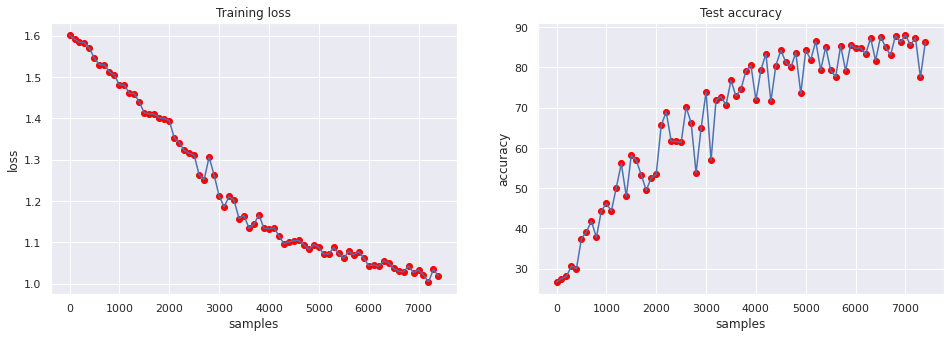

Finished Training


In [13]:
losses = []
scores = []
out = Output()
display.display(out)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, net)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0

print('Finished Training')

Получили уже очень хороший результат на baseline. Попробуем улучшить результат

In [14]:
from torchsummary import summary
summary(net, (1, 160, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 156, 124]           1,664
       BatchNorm2d-2         [-1, 64, 156, 124]             128
           Dropout-3         [-1, 64, 156, 124]               0
            Conv2d-4        [-1, 128, 152, 120]         204,928
       BatchNorm2d-5        [-1, 128, 152, 120]             256
         MaxPool2d-6          [-1, 128, 76, 60]               0
            Conv2d-7          [-1, 256, 72, 56]         819,456
       BatchNorm2d-8          [-1, 256, 72, 56]             512
         MaxPool2d-9          [-1, 256, 18, 14]               0
           Conv2d-10          [-1, 256, 14, 10]       1,638,656
      BatchNorm2d-11          [-1, 256, 14, 10]             512
        MaxPool2d-12            [-1, 256, 2, 1]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                  [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train a model: finally, lets' build and train a classifier neural network. You can use any library you like. If in doubt, consult the model & training tips below.

__Training tips:__ here's what you can try:
* __Layers:__ 1d or 2d convolutions, perhaps with some batch normalization in between;
* __Architecture:__ VGG-like, residual, highway, densely-connected, MatchboxNet, Dilated convs - you name it :)
* __Batch size matters:__ smaller batches usually train slower but better. Try to find the one that suits you best.
* __Data augmentation:__ add background noise, faster/slower, change pitch;
* __Average checkpoints:__ you can make model more stable with [this simple technique (arxiv)](https://arxiv.org/abs/1803.05407)
* __For full scale stage:__ make sure you're not losing too much data due to max_length in the pre-processing stage!

These are just recommendations. As long as your model works, you're not required to follow them.

#### Densely-connected

Реализуем densely-connected и посмотрим на результат  
туториал https://towardsdatascience.com/simple-implementation-of-densely-connected-convolutional-networks-in-pytorch-3846978f2f36  

Также добавим scheduler, умножающий learning rate на 0.1 каждую пятую эпоху

In [15]:
class Dense_Block(nn.Module):
  def __init__(self, in_channels):
    super(Dense_Block, self).__init__()
    self.relu = nn.ReLU(inplace = True)
    self.bn = nn.BatchNorm2d(in_channels)

    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
  
  def forward(self, x):
    bn = self.bn(x)
    conv1 = self.relu(self.conv1(bn))
    conv2 = self.relu(self.conv2(conv1))
    # Concatenate in channel dimension
    c2_dense = self.relu(torch.cat([conv1, conv2], 1))
    conv3 = self.relu(self.conv3(c2_dense))
    c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

    conv4 = self.relu(self.conv4(c3_dense))
    c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

    conv5 = self.relu(self.conv5(c4_dense))
    c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

    return c5_dense

class Transition_Layer(nn.Module): 
  def __init__(self, in_channels, out_channels):
    super(Transition_Layer, self).__init__() 

    self.relu = nn.ReLU(inplace = True) 
    self.bn = nn.BatchNorm2d(num_features = out_channels) 
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False) 
    self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0) 

  def forward(self, x): 
    bn = self.bn(self.relu(self.conv(x))) 
    out = self.avg_pool(bn) 
    return out

import torch.nn as nn
import torch.nn.functional as F


class NetDense(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(Dense_Block, 128) 
        self.denseblock2 = self._make_dense_block(Dense_Block, 160)
        self.denseblock3 = self._make_dense_block(Dense_Block, 160)
        # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 128, out_channels = 128) 
        self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 128, out_channels = 128)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(3)
        # self.conv4 = nn.Conv2d(256, 128, 5)
        # self.bn4 = nn.BatchNorm2d(128)
        # self.pool3 = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 64)
        self.dense2 = nn.Linear(64, 5)

    def _make_dense_block(self, block, in_channels): 
      layers = [] 
      layers.append(block(in_channels)) 
      return nn.Sequential(*layers) 
    def _make_transition_layer(self, layer, in_channels, out_channels): 
      modules = [] 
      modules.append(layer(in_channels, out_channels)) 
      return nn.Sequential(*modules) 

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.denseblock1(x)
        x = self.denseblock2(x)
        x = self.denseblock3(x)
        x = self.transitionLayer1(x)
        x = self.transitionLayer2(x)
        x = self.transitionLayer3(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        # x = self.conv4(x)
        # x = self.bn4(x)
        # x = F.relu(x)
        # x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.softmax(x)
        return x


net_dense = NetDense().to(device)

In [16]:
from torchsummary import summary
summary(net_dense, (1, 160, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 156, 124]           1,664
       BatchNorm2d-2         [-1, 64, 156, 124]             128
           Dropout-3         [-1, 64, 156, 124]               0
            Conv2d-4        [-1, 128, 152, 120]         204,928
       BatchNorm2d-5        [-1, 128, 152, 120]             256
         MaxPool2d-6          [-1, 128, 76, 60]               0
       BatchNorm2d-7          [-1, 128, 76, 60]             256
            Conv2d-8           [-1, 32, 76, 60]          36,896
              ReLU-9           [-1, 32, 76, 60]               0
           Conv2d-10           [-1, 32, 76, 60]           9,248
             ReLU-11           [-1, 32, 76, 60]               0
             ReLU-12           [-1, 64, 76, 60]               0
           Conv2d-13           [-1, 32, 76, 60]          18,464
             ReLU-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [30]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net_dense.parameters(), lr=0.001)
optimizer = optim.SGD(net_dense.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net_dense(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, net_dense)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

Output()

  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:113: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 0.985, accuracy: 53.261
[1,   200] loss: 0.972, accuracy: 53.870
[1,   300] loss: 0.990, accuracy: 67.726
[1,   400] loss: 0.975, accuracy: 70.260
[1,   500] loss: 0.973, accuracy: 45.522


  0%|          | 0/555 [00:00<?, ?it/s]

[2,   100] loss: 0.963, accuracy: 67.692
[2,   200] loss: 0.977, accuracy: 77.729
[2,   300] loss: 0.974, accuracy: 69.483
[2,   400] loss: 0.966, accuracy: 59.209
[2,   500] loss: 0.973, accuracy: 53.498


  0%|          | 0/555 [00:00<?, ?it/s]

[3,   100] loss: 0.969, accuracy: 79.689
[3,   200] loss: 0.959, accuracy: 53.768
[3,   300] loss: 0.967, accuracy: 66.847
[3,   400] loss: 0.965, accuracy: 56.844
[3,   500] loss: 0.973, accuracy: 58.635


  0%|          | 0/555 [00:00<?, ?it/s]

[4,   100] loss: 0.966, accuracy: 49.172
[4,   200] loss: 0.969, accuracy: 66.340
[4,   300] loss: 0.963, accuracy: 47.246
[4,   400] loss: 0.962, accuracy: 63.062
[4,   500] loss: 0.969, accuracy: 64.988


  0%|          | 0/555 [00:00<?, ?it/s]

[5,   100] loss: 0.949, accuracy: 68.165
[5,   200] loss: 0.960, accuracy: 73.707
[5,   300] loss: 0.968, accuracy: 66.408
[5,   400] loss: 0.958, accuracy: 62.420
[5,   500] loss: 0.966, accuracy: 46.874


  0%|          | 0/555 [00:00<?, ?it/s]

[6,   100] loss: 0.953, accuracy: 49.104
[6,   200] loss: 0.954, accuracy: 54.072
[6,   300] loss: 0.949, accuracy: 53.058
[6,   400] loss: 0.941, accuracy: 61.913
[6,   500] loss: 0.946, accuracy: 54.883


  0%|          | 0/555 [00:00<?, ?it/s]

[7,   100] loss: 0.941, accuracy: 54.714
[7,   200] loss: 0.947, accuracy: 59.175
[7,   300] loss: 0.945, accuracy: 49.476
[7,   400] loss: 0.948, accuracy: 64.887
[7,   500] loss: 0.939, accuracy: 56.438


  0%|          | 0/555 [00:00<?, ?it/s]

[8,   100] loss: 0.935, accuracy: 59.784
[8,   200] loss: 0.949, accuracy: 59.040
[8,   300] loss: 0.942, accuracy: 61.778
[8,   400] loss: 0.943, accuracy: 57.891
[8,   500] loss: 0.946, accuracy: 63.839


  0%|          | 0/555 [00:00<?, ?it/s]

[9,   100] loss: 0.947, accuracy: 56.201
[9,   200] loss: 0.939, accuracy: 69.956
[9,   300] loss: 0.942, accuracy: 67.252
[9,   400] loss: 0.938, accuracy: 61.440
[9,   500] loss: 0.936, accuracy: 57.148


  0%|          | 0/555 [00:00<?, ?it/s]

[10,   100] loss: 0.939, accuracy: 71.713
[10,   200] loss: 0.943, accuracy: 67.726
[10,   300] loss: 0.944, accuracy: 66.610
[10,   400] loss: 0.943, accuracy: 56.404
[10,   500] loss: 0.943, accuracy: 62.656
Finished Training


Результат получился хуже. Пробуем другой подход

#### VGG 19

Источник:  
https://github.com/tugstugi/pytorch-speech-commands.git

In [31]:
!git clone https://github.com/tugstugi/pytorch-speech-commands.git

Cloning into 'pytorch-speech-commands'...
remote: Enumerating objects: 296, done.
remote: Total 296 (delta 0), reused 0 (delta 0), pack-reused 296
Receiving objects: 100% (296/296), 56.40 KiB | 5.13 MiB/s, done.
Resolving deltas: 100% (174/174), done.


In [32]:
%cd pytorch-speech-commands/models/

/content/pytorch-speech-commands/models


In [33]:
from vgg import *
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
def make_layers(cfg, batch_norm=False, in_channels = 3):
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg19(pretrained=False, in_channels=3, **kwargs):
  """VGG 19-layer model (configuration "E")
  Args:
      pretrained (bool): If True, returns a model pre-trained on ImageNet
  """
  if pretrained:
      kwargs['init_weights'] = False
  model = VGG(make_layers(cfg['E'], in_channels=in_channels), **kwargs)
  if pretrained:
      model.load_state_dict(model_zoo.load_url(model_urls['vgg19']))
  return model

In [37]:
net_vgg_19 = vgg19(in_channels=1, num_classes=5)
net_vgg_19.classifier[0] = nn.Linear(in_features=10240, out_features=4096, bias=True)
net_vgg_19 = net_vgg_19.to(device)

In [42]:
net_vgg_19

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [41]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net_vgg_19.parameters(), lr=0.001)
optimizer = optim.SGD(net_vgg_19.parameters(), lr=0.01, momentum=0.9)

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_vgg_19(inputs)
        outputs = torch.nn.functional.softmax(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, net_vgg_19)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0
    #scheduler.step()

print('Finished Training')

Output()

  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 1.703, accuracy: 20.210
[1,   200] loss: 1.704, accuracy: 20.210
[1,   300] loss: 1.712, accuracy: 20.210
[1,   400] loss: 1.704, accuracy: 20.210
[1,   500] loss: 1.690, accuracy: 20.210


  0%|          | 0/555 [00:00<?, ?it/s]

[2,   100] loss: 1.714, accuracy: 20.210
[2,   200] loss: 1.695, accuracy: 20.210
[2,   300] loss: 1.699, accuracy: 20.210


KeyboardInterrupt: ignored

Результат ещё хуже

#### KWTNet

Источник:  
https://arxiv.org/abs/2104.00769  
https://github.com/ID56/Torch-KWT

In [53]:
!pip install einops

In [63]:
import torch
import torch.fft
import torch.nn.functional as F
from torch import nn, einsum

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


# Basically vision transformer, ViT that accepts MFCC + SpecAug. Refer to:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.norm(self.fn(x, **kwargs))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, pre_norm=True, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        
        P_Norm = PreNorm if pre_norm else PostNorm

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                P_Norm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                P_Norm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class KWT(nn.Module):
    def __init__(self, input_res, patch_res, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 1, dim_head = 64, dropout = 0., emb_dropout = 0., pre_norm = True, **kwargs):
        super().__init__()
        
        num_patches = int(input_res[0]/patch_res[0] * input_res[1]/patch_res[1])
        
        patch_dim = channels * patch_res[0] * patch_res[1]
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_res[0], p2 = patch_res[1]),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, pre_norm, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        ) 
        
    def forward(self, x):
        x = self.to_patch_embedding(x)
        
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


def kwt_from_name(model_name: str):

    models = {
        "kwt-1": {
            "input_res": [40, 98],
            "patch_res": [40, 1],
            "num_classes": 35,
            "mlp_dim": 256,
            "dim": 64,
            "heads": 1,
            "depth": 12,
            "dropout": 0.0,
            "emb_dropout": 0.1,
            "pre_norm": False
        },

        "kwt-2": {
            "input_res": [40, 98],
            "patch_res": [40, 1],
            "num_classes": 35,
            "mlp_dim": 512,
            "dim": 128,
            "heads": 2,
            "depth": 12,
            "dropout": 0.0,
            "emb_dropout": 0.1,
            "pre_norm": False
        },

        "kwt-3": {
            "input_res": [40, 98],
            "patch_res": [40, 1],
            "num_classes": 35,
            "mlp_dim": 768,
            "dim": 192,
            "heads": 3,
            "depth": 12,
            "dropout": 0.0,
            "emb_dropout": 0.1,
            "pre_norm": False
        },

        "kwt-4": {
            "input_res": [40, 512],
            "patch_res": [40, 1],
            "num_classes": 5,
            "mlp_dim": 256,
            "dim": 64,
            "heads": 1,
            "depth": 12,
            "dropout": 0.0,
            "emb_dropout": 0.1,
            "pre_norm": False
        },
    }

    assert model_name in models.keys(), f"Unsupported model_name {model_name}; must be one of {list(models.keys())}"

    return KWT(**models[model_name])

kwtnet = kwt_from_name('kwt-4').to(device)

In [64]:
kwtnet

KWT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=40, p2=1)
    (1): Linear(in_features=40, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PostNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=192, bias=False)
            (to_out): Identity()
          )
        )
        (1): PostNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=256, bias=True)
              (1): GELU()
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=256, out_features=64, bias=True)
              (4): Dropout(p=0.0, inpla

In [65]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(kwtnet.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = kwtnet(inputs)
        outputs = torch.nn.functional.softmax(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, kwtnet)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0

print('Finished Training')

Output()

  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 1.607, accuracy: 22.541
[1,   200] loss: 1.607, accuracy: 22.609
[1,   300] loss: 1.606, accuracy: 25.921
[1,   400] loss: 1.603, accuracy: 25.448
[1,   500] loss: 1.602, accuracy: 26.394


  0%|          | 0/555 [00:00<?, ?it/s]

[2,   100] loss: 1.597, accuracy: 25.887
[2,   200] loss: 1.592, accuracy: 25.752
[2,   300] loss: 1.593, accuracy: 25.583
[2,   400] loss: 1.592, accuracy: 26.428
[2,   500] loss: 1.589, accuracy: 26.394


  0%|          | 0/555 [00:00<?, ?it/s]

[3,   100] loss: 1.579, accuracy: 28.760
[3,   200] loss: 1.575, accuracy: 29.976
[3,   300] loss: 1.566, accuracy: 29.605
[3,   400] loss: 1.567, accuracy: 29.064
[3,   500] loss: 1.571, accuracy: 29.740


  0%|          | 0/555 [00:00<?, ?it/s]

[4,   100] loss: 1.552, accuracy: 29.131
[4,   200] loss: 1.556, accuracy: 31.125
[4,   300] loss: 1.557, accuracy: 29.233
[4,   400] loss: 1.571, accuracy: 29.638
[4,   500] loss: 1.556, accuracy: 30.720


  0%|          | 0/555 [00:00<?, ?it/s]

[5,   100] loss: 1.560, accuracy: 32.477
[5,   200] loss: 1.550, accuracy: 31.970
[5,   300] loss: 1.541, accuracy: 32.612
[5,   400] loss: 1.547, accuracy: 31.734
[5,   500] loss: 1.563, accuracy: 28.489


  0%|          | 0/555 [00:00<?, ?it/s]

[6,   100] loss: 1.554, accuracy: 26.428
[6,   200] loss: 1.560, accuracy: 32.105
[6,   300] loss: 1.555, accuracy: 32.376
[6,   400] loss: 1.538, accuracy: 32.342
[6,   500] loss: 1.557, accuracy: 32.410


  0%|          | 0/555 [00:00<?, ?it/s]

[7,   100] loss: 1.532, accuracy: 33.491
[7,   200] loss: 1.522, accuracy: 34.877
[7,   300] loss: 1.537, accuracy: 34.572
[7,   400] loss: 1.544, accuracy: 32.984
[7,   500] loss: 1.536, accuracy: 34.066


  0%|          | 0/555 [00:00<?, ?it/s]

[8,   100] loss: 1.525, accuracy: 34.944
[8,   200] loss: 1.516, accuracy: 35.519
[8,   300] loss: 1.530, accuracy: 33.660
[8,   400] loss: 1.537, accuracy: 30.382
[8,   500] loss: 1.525, accuracy: 35.755


  0%|          | 0/555 [00:00<?, ?it/s]

[9,   100] loss: 1.527, accuracy: 35.316
[9,   200] loss: 1.532, accuracy: 33.356
[9,   300] loss: 1.524, accuracy: 32.748
[9,   400] loss: 1.535, accuracy: 34.099
[9,   500] loss: 1.544, accuracy: 34.572


  0%|          | 0/555 [00:00<?, ?it/s]

[10,   100] loss: 1.523, accuracy: 35.823
[10,   200] loss: 1.528, accuracy: 36.195
[10,   300] loss: 1.517, accuracy: 35.586
[10,   400] loss: 1.517, accuracy: 34.978
[10,   500] loss: 1.534, accuracy: 35.046
Finished Training


#### BCResNet

Источник:  
https://arxiv.org/abs/2106.04140  
https://github.com/roman-vygon/BCResNet

In [49]:
import torch
from torch import Tensor
import torch.nn as nn


class SubSpectralNorm(nn.Module):
    def __init__(self, C, S, eps=1e-5):
        super(SubSpectralNorm, self).__init__()
        self.S = S
        self.eps = eps
        self.bn = nn.BatchNorm2d(C*S)

    def forward(self, x):
        # x: input features with shape {N, C, F, T}
        # S: number of sub-bands
        N, C, F, T = x.size()
        x = x.view(N, C * self.S, F // self.S, T)

        x = self.bn(x)

        return x.view(N, C, F, T)


class BroadcastedBlock(nn.Module):
    def __init__(
            self,
            planes: int,
            dilation=1,
            stride=1,
            temp_pad=(0, 1),
    ) -> None:
        super(BroadcastedBlock, self).__init__()

        self.freq_dw_conv = nn.Conv2d(planes, planes, kernel_size=(3, 1), padding=(1, 0), groups=planes,
                                      dilation=dilation,
                                      stride=stride, bias=False)
        self.ssn1 = SubSpectralNorm(planes, 5)
        self.temp_dw_conv = nn.Conv2d(planes, planes, kernel_size=(1, 3), padding=temp_pad, groups=planes,
                                      dilation=dilation, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.channel_drop = nn.Dropout2d(p=0.5)
        self.swish = nn.SiLU()
        self.conv1x1 = nn.Conv2d(planes, planes, kernel_size=(1, 1), bias=False)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        # f2
        ##########################
        out = self.freq_dw_conv(x)
        out = self.ssn1(out)
        ##########################

        auxilary = out
        out = out.mean(2, keepdim=True)  # frequency average pooling

        # f1
        ############################
        out = self.temp_dw_conv(out)
        out = self.bn(out)
        out = self.swish(out)
        out = self.conv1x1(out)
        out = self.channel_drop(out)
        ############################

        out = out + identity + auxilary
        out = self.relu(out)

        return out


class TransitionBlock(nn.Module):

    def __init__(
            self,
            inplanes: int,
            planes: int,
            dilation=1,
            stride=1,
            temp_pad=(0, 1),
    ) -> None:
        super(TransitionBlock, self).__init__()

        self.freq_dw_conv = nn.Conv2d(planes, planes, kernel_size=(3, 1), padding=(1, 0), groups=planes,
                                      stride=stride,
                                      dilation=dilation, bias=False)
        self.ssn = SubSpectralNorm(planes, 5)
        self.temp_dw_conv = nn.Conv2d(planes, planes, kernel_size=(1, 3), padding=temp_pad, groups=planes,
                                      dilation=dilation, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.channel_drop = nn.Dropout2d(p=0.5)
        self.swish = nn.SiLU()
        self.conv1x1_1 = nn.Conv2d(inplanes, planes, kernel_size=(1, 1), bias=False)
        self.conv1x1_2 = nn.Conv2d(planes, planes, kernel_size=(1, 1), bias=False)

    def forward(self, x: Tensor) -> Tensor:
        # f2
        #############################
        out = self.conv1x1_1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.freq_dw_conv(out)
        out = self.ssn(out)
        #############################
        auxilary = out
        out = out.mean(2, keepdim=True)  # frequency average pooling

        # f1
        #############################
        out = self.temp_dw_conv(out)
        out = self.bn2(out)
        out = self.swish(out)
        out = self.conv1x1_2(out)
        out = self.channel_drop(out)
        #############################

        out = auxilary + out
        out = self.relu(out)

        return out


class BCResNet(torch.nn.Module):
    def __init__(self):
        super(BCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=(2, 1), padding=(2, 2))
        self.block1_1 = TransitionBlock(16, 8)
        self.block1_2 = BroadcastedBlock(8)

        self.block2_1 = TransitionBlock(8, 12, stride=(2, 1), dilation=(1, 2), temp_pad=(0, 2))
        self.block2_2 = BroadcastedBlock(12, dilation=(1, 2), temp_pad=(0, 2))

        self.block3_1 = TransitionBlock(12, 16, stride=(2, 1), dilation=(1, 4), temp_pad=(0, 4))
        self.block3_2 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))
        self.block3_3 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))
        self.block3_4 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))

        self.block4_1 = TransitionBlock(16, 20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_2 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_3 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_4 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))

        self.conv2 = nn.Conv2d(20, 20, 5, groups=20, padding=(0, 2))
        self.conv3 = nn.Conv2d(20, 32, 1, bias=False)
        self.conv4 = nn.Conv2d(32, 12, 1, bias=False)

        self.adapt = nn.AdaptiveMaxPool2d((5,7))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(420, 120)
        self.dense2 = nn.Linear(120, 5)

    def forward(self, x):

        #print('INPUT SHAPE:', x.shape)
        out = self.conv1(x)

        #print('BLOCK1 INPUT SHAPE:', out.shape)
        out = self.block1_1(out)
        out = self.block1_2(out)

        #print('BLOCK2 INPUT SHAPE:', out.shape)
        out = self.block2_1(out)
        out = self.block2_2(out)

        #print('BLOCK3 INPUT SHAPE:', out.shape)
        out = self.block3_1(out)
        out = self.block3_2(out)
        out = self.block3_3(out)
        out = self.block3_4(out)

        #print('BLOCK4 INPUT SHAPE:', out.shape)
        out = self.block4_1(out)
        out = self.block4_2(out)
        out = self.block4_3(out)
        out = self.block4_4(out)

        #print('Conv2 INPUT SHAPE:', out.shape)
        out = self.conv2(out)

        #print('Conv3 INPUT SHAPE:', out.shape)
        out = self.conv3(out)
        out = out.mean(-1, keepdim=True)

        #print('Conv4 INPUT SHAPE:', out.shape)
        out = self.conv4(out)

        out = self.adapt(out)
        out = self.flatten(out)
        #print("------------>", out.shape)
        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        out = F.softmax(out)

        #print('OUTPUT SHAPE:', out.shape)
        return out

bcresnet = BCResNet().to(device)

In [52]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(bcresnet.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(bcresnet.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = bcresnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, bcresnet)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

Output()

  0%|          | 0/555 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 1.464, accuracy: 19.703
[1,   200] loss: 1.476, accuracy: 32.105
[1,   300] loss: 1.478, accuracy: 19.669


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3466c1ba70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3466c1ba70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

[1,   400] loss: 1.483, accuracy: 25.718
[1,   500] loss: 1.479, accuracy: 20.176


  0%|          | 0/555 [00:00<?, ?it/s]

[2,   100] loss: 1.489, accuracy: 32.376
[2,   200] loss: 1.474, accuracy: 19.804
[2,   300] loss: 1.497, accuracy: 25.786
[2,   400] loss: 1.482, accuracy: 21.021
[2,   500] loss: 1.484, accuracy: 20.649


  0%|          | 0/555 [00:00<?, ?it/s]

[3,   100] loss: 1.485, accuracy: 28.320
[3,   200] loss: 1.495, accuracy: 20.142
[3,   300] loss: 1.488, accuracy: 29.098
[3,   400] loss: 1.480, accuracy: 23.352
[3,   500] loss: 1.459, accuracy: 37.107


  0%|          | 0/555 [00:00<?, ?it/s]

[4,   100] loss: 1.472, accuracy: 21.359
[4,   200] loss: 1.480, accuracy: 20.176
[4,   300] loss: 1.480, accuracy: 25.853
[4,   400] loss: 1.477, accuracy: 21.561
[4,   500] loss: 1.448, accuracy: 31.328


  0%|          | 0/555 [00:00<?, ?it/s]

[5,   100] loss: 1.457, accuracy: 20.885
[5,   200] loss: 1.461, accuracy: 40.858
[5,   300] loss: 1.541, accuracy: 27.509
[5,   400] loss: 1.556, accuracy: 29.436
[5,   500] loss: 1.538, accuracy: 20.311


  0%|          | 0/555 [00:00<?, ?it/s]

[6,   100] loss: 1.529, accuracy: 21.730
[6,   200] loss: 1.527, accuracy: 22.034
[6,   300] loss: 1.522, accuracy: 27.002
[6,   400] loss: 1.520, accuracy: 24.704
[6,   500] loss: 1.542, accuracy: 35.113


  0%|          | 0/555 [00:00<?, ?it/s]

[7,   100] loss: 1.506, accuracy: 35.248
[7,   200] loss: 1.522, accuracy: 23.048
[7,   300] loss: 1.519, accuracy: 35.553
[7,   400] loss: 1.511, accuracy: 40.554
[7,   500] loss: 1.517, accuracy: 23.285


  0%|          | 0/555 [00:00<?, ?it/s]

[8,   100] loss: 1.505, accuracy: 33.525
[8,   200] loss: 1.504, accuracy: 28.523
[8,   300] loss: 1.515, accuracy: 30.923
[8,   400] loss: 1.507, accuracy: 26.664
[8,   500] loss: 1.503, accuracy: 24.975


  0%|          | 0/555 [00:00<?, ?it/s]

[9,   100] loss: 1.513, accuracy: 30.551
[9,   200] loss: 1.498, accuracy: 27.611
[9,   300] loss: 1.490, accuracy: 22.710
[9,   400] loss: 1.515, accuracy: 34.640
[9,   500] loss: 1.493, accuracy: 25.989


  0%|          | 0/555 [00:00<?, ?it/s]

[10,   100] loss: 1.492, accuracy: 23.116
[10,   200] loss: 1.511, accuracy: 27.678
[10,   300] loss: 1.495, accuracy: 21.697
[10,   400] loss: 1.498, accuracy: 21.156
[10,   500] loss: 1.479, accuracy: 21.832
Finished Training


#### Итоги

Лучше всего показал себя BaseLine с семинара

### Full scale commands recognition (3+ points)

Your final task is to train a full-scale voice command spotter and apply it to a video:
1. Build the dataset with all 30+ classes (directions, digits, names, etc.)
  * __Optional:__ include a special "noise" class that contains random unrelated sounds
  * You can download youtube videos with [`youtube-dl`](https://ytdl-org.github.io/youtube-dl/index.html) library.
2. Train a model on this full dataset. Kudos for tuning its accuracy :)
3. Apply it to a audio/video of your choice to spot the occurences of each keyword
 * Here's one [video about primes](https://www.youtube.com/watch?v=EK32jo7i5LQ) that you can try. It should be full of numbers :)
 * There are multiple ways you can analyze the performance of your network, e.g. plot probabilities predicted for every time-step. Chances are you'll discover something useful about how to improve your model :)


Please briefly describe what you did in a short informal report.

Натренеруем лучшую модель из предыдущего задания на все 31 классов

In [3]:
%cd /content/
!rm -r ./speech_commands

datadir = "speech_commands"

!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
!mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

samples_by_target = {
    cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls)) if 'README.md' not in name]
    for cls in os.listdir(datadir)
    if os.path.isdir(os.path.join(datadir, cls))
}
classes = list(samples_by_target.keys())
print('Classes:', ', '.join(sorted(classes)))

/content
rm: cannot remove './speech_commands': No such file or directory
--2021-10-27 06:06:00--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.142.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.142.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   181MB/s    in 11s     

2021-10-27 06:06:11 (124 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]

Classes: _background_noise_, bed, bird, cat, dog, down, eight, five, four, go, happy, house, left, marvin, nine, no, off, on, one, right, seven, sheila, six, stop, three, tree, two, up, wow, yes, zero


In [4]:
print(len(classes))

31


In [5]:
def preprocess_sample(filepath, max_length=160):
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = classes.index(filepath.split(os.sep)[-2])
    #print(target)
    return np.float32(spectrogram), np.int64(target)

all_files = chain(*(samples_by_target[cls] for cls in classes))

spectrograms_and_targets = jl.Parallel(n_jobs=-1)(tqdm(list(map(jl.delayed(preprocess_sample), all_files))))
#spectrograms_and_targets = list(map(preprocess_sample, all_files))
X, y = map(np.stack, zip(*spectrograms_and_targets))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

  0%|          | 0/64727 [00:00<?, ?it/s]

In [6]:
print('Train before: {}'.format(X_train.shape))
print('Test before: {}'.format(X_test.shape))
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print('Train after: {}'.format(X_train.shape))
print('Test after: {}'.format(X_test.shape))

Train before: (48545, 160, 128)
Test before: (16182, 160, 128)
Train after: (48545, 1, 160, 128)
Test after: (16182, 1, 160, 128)


In [7]:
if torch.cuda.is_available:
  device = 'cuda'
else:
  device = 'cpu'

batch_size = 16

tensor_x = torch.Tensor(X_train)
tensor_y = torch.LongTensor(y_train)

train_dataset = TensorDataset(tensor_x, tensor_y)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.LongTensor(y_test)

test_dataset = TensorDataset(tensor_x, tensor_y)


trainloader = DataLoader(train_dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [8]:
X_train.shape

(48545, 1, 160, 128)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define your layers here
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(4)
        self.conv4 = nn.Conv2d(256, 256, 5)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(6)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512, 256)
        self.dense2 = nn.Linear(256, 31)

    def forward(self, x):
        # TODO: apply your layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.softmax(x)
        return x


net = Net().to(device)

In [10]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        #print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()
    return float(num_correct)/float(num_samples)*100

In [11]:
import seaborn as sns
sns.set()
from IPython.display import clear_output, display

import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

from ipywidgets import Output

def plot_progress(losses, scores, disp):
  with disp:
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot([i*100 for i in range(len(losses))], losses)
    ax[1].plot([i*100 for i in range(len(scores))], scores)
    ax[0].scatter([i*100 for i in range(len(losses))], losses, color='red')
    ax[1].scatter([i*100 for i in range(len(scores))], scores, color='red')


    ax[0].set(xlabel='samples', ylabel='loss',
          title=f'Training loss')
    ax[1].set(xlabel='samples', ylabel='accuracy',
          title=f'Test accuracy')
    clear_output(wait=True)
    plt.show()
  time.sleep(1)

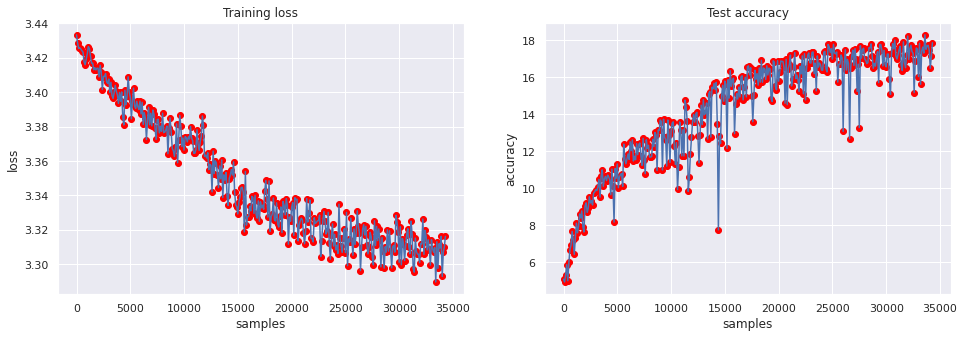

KeyboardInterrupt: ignored

In [12]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, net)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0

print('Finished Training')

In [59]:
from google.colab import files
path_to_save = "baseline_model.pth"
torch.save(net.state_dict(), path_to_save)
files.download(path_to_save )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### BCResNet

Источник:  
https://arxiv.org/abs/2106.04140  
https://github.com/roman-vygon/BCResNet

In [28]:
import torch
from torch import Tensor
import torch.nn as nn


class SubSpectralNorm(nn.Module):
    def __init__(self, C, S, eps=1e-5):
        super(SubSpectralNorm, self).__init__()
        self.S = S
        self.eps = eps
        self.bn = nn.BatchNorm2d(C*S)

    def forward(self, x):
        # x: input features with shape {N, C, F, T}
        # S: number of sub-bands
        N, C, F, T = x.size()
        x = x.view(N, C * self.S, F // self.S, T)

        x = self.bn(x)

        return x.view(N, C, F, T)


class BroadcastedBlock(nn.Module):
    def __init__(
            self,
            planes: int,
            dilation=1,
            stride=1,
            temp_pad=(0, 1),
    ) -> None:
        super(BroadcastedBlock, self).__init__()

        self.freq_dw_conv = nn.Conv2d(planes, planes, kernel_size=(3, 1), padding=(1, 0), groups=planes,
                                      dilation=dilation,
                                      stride=stride, bias=False)
        self.ssn1 = SubSpectralNorm(planes, 5)
        self.temp_dw_conv = nn.Conv2d(planes, planes, kernel_size=(1, 3), padding=temp_pad, groups=planes,
                                      dilation=dilation, stride=stride, bias=False)
        self.bn = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.channel_drop = nn.Dropout2d(p=0.5)
        self.swish = nn.SiLU()
        self.conv1x1 = nn.Conv2d(planes, planes, kernel_size=(1, 1), bias=False)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        # f2
        ##########################
        out = self.freq_dw_conv(x)
        out = self.ssn1(out)
        ##########################

        auxilary = out
        out = out.mean(2, keepdim=True)  # frequency average pooling

        # f1
        ############################
        out = self.temp_dw_conv(out)
        out = self.bn(out)
        out = self.swish(out)
        out = self.conv1x1(out)
        out = self.channel_drop(out)
        ############################

        out = out + identity + auxilary
        out = self.relu(out)

        return out


class TransitionBlock(nn.Module):

    def __init__(
            self,
            inplanes: int,
            planes: int,
            dilation=1,
            stride=1,
            temp_pad=(0, 1),
    ) -> None:
        super(TransitionBlock, self).__init__()

        self.freq_dw_conv = nn.Conv2d(planes, planes, kernel_size=(3, 1), padding=(1, 0), groups=planes,
                                      stride=stride,
                                      dilation=dilation, bias=False)
        self.ssn = SubSpectralNorm(planes, 5)
        self.temp_dw_conv = nn.Conv2d(planes, planes, kernel_size=(1, 3), padding=temp_pad, groups=planes,
                                      dilation=dilation, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.channel_drop = nn.Dropout2d(p=0.5)
        self.swish = nn.SiLU()
        self.conv1x1_1 = nn.Conv2d(inplanes, planes, kernel_size=(1, 1), bias=False)
        self.conv1x1_2 = nn.Conv2d(planes, planes, kernel_size=(1, 1), bias=False)

    def forward(self, x: Tensor) -> Tensor:
        # f2
        #############################
        out = self.conv1x1_1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.freq_dw_conv(out)
        out = self.ssn(out)
        #############################
        auxilary = out
        out = out.mean(2, keepdim=True)  # frequency average pooling

        # f1
        #############################
        out = self.temp_dw_conv(out)
        out = self.bn2(out)
        out = self.swish(out)
        out = self.conv1x1_2(out)
        out = self.channel_drop(out)
        #############################

        out = auxilary + out
        out = self.relu(out)

        return out


class BCResNet(torch.nn.Module):
    def __init__(self):
        super(BCResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=(2, 1), padding=(2, 2))
        self.block1_1 = TransitionBlock(16, 8)
        self.block1_2 = BroadcastedBlock(8)

        self.block2_1 = TransitionBlock(8, 12, stride=(2, 1), dilation=(1, 2), temp_pad=(0, 2))
        self.block2_2 = BroadcastedBlock(12, dilation=(1, 2), temp_pad=(0, 2))

        self.block3_1 = TransitionBlock(12, 16, stride=(2, 1), dilation=(1, 4), temp_pad=(0, 4))
        self.block3_2 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))
        self.block3_3 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))
        self.block3_4 = BroadcastedBlock(16, dilation=(1, 4), temp_pad=(0, 4))

        self.block4_1 = TransitionBlock(16, 20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_2 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_3 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))
        self.block4_4 = BroadcastedBlock(20, dilation=(1, 8), temp_pad=(0, 8))

        self.conv2 = nn.Conv2d(20, 20, 5, groups=20, padding=(0, 2))
        self.conv3 = nn.Conv2d(20, 32, 1, bias=False)
        self.conv4 = nn.Conv2d(32, 12, 1, bias=False)

        self.adapt = nn.AdaptiveMaxPool2d((5,7))
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(420, 120)
        self.dense2 = nn.Linear(120, 31)

    def forward(self, x):

        #print('INPUT SHAPE:', x.shape)
        out = self.conv1(x)

        #print('BLOCK1 INPUT SHAPE:', out.shape)
        out = self.block1_1(out)
        out = self.block1_2(out)

        #print('BLOCK2 INPUT SHAPE:', out.shape)
        out = self.block2_1(out)
        out = self.block2_2(out)

        #print('BLOCK3 INPUT SHAPE:', out.shape)
        out = self.block3_1(out)
        out = self.block3_2(out)
        out = self.block3_3(out)
        out = self.block3_4(out)

        #print('BLOCK4 INPUT SHAPE:', out.shape)
        out = self.block4_1(out)
        out = self.block4_2(out)
        out = self.block4_3(out)
        out = self.block4_4(out)

        #print('Conv2 INPUT SHAPE:', out.shape)
        out = self.conv2(out)

        #print('Conv3 INPUT SHAPE:', out.shape)
        out = self.conv3(out)
        out = out.mean(-1, keepdim=True)

        #print('Conv4 INPUT SHAPE:', out.shape)
        out = self.conv4(out)

        out = self.adapt(out)
        out = self.flatten(out)
        #print("------------>", out.shape)
        out = self.dense1(out)
        out = F.relu(out)
        out = self.dense2(out)
        out = F.softmax(out)

        #print('OUTPUT SHAPE:', out.shape)
        return out

bcresnet = BCResNet().to(device)

In [32]:
losses = []
scores = []
out = Output()
display(out)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(bcresnet.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(bcresnet.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = bcresnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            acc = get_accuracy(testloader, bcresnet)
            print('[%d, %5d] loss: %.3f, accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, acc))
            losses.append(running_loss / 100)
            scores.append(acc)
            plot_progress(losses, scores, out)
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

Output()

  0%|          | 0/3035 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[1,   100] loss: 3.433, accuracy: 3.504
[1,   200] loss: 3.431, accuracy: 3.479
[1,   300] loss: 3.431, accuracy: 3.510
[1,   400] loss: 3.431, accuracy: 3.689
[1,   500] loss: 3.431, accuracy: 3.689
[1,   600] loss: 3.429, accuracy: 3.541
[1,   700] loss: 3.432, accuracy: 3.689
[1,   800] loss: 3.432, accuracy: 3.566
[1,   900] loss: 3.430, accuracy: 3.603
[1,  1000] loss: 3.430, accuracy: 3.467
[1,  1100] loss: 3.430, accuracy: 3.479
[1,  1200] loss: 3.430, accuracy: 3.739
[1,  1300] loss: 3.432, accuracy: 3.547
[1,  1400] loss: 3.430, accuracy: 3.510
[1,  1500] loss: 3.429, accuracy: 3.479
[1,  1600] loss: 3.430, accuracy: 3.479
[1,  1700] loss: 3.433, accuracy: 3.974
[1,  1800] loss: 3.429, accuracy: 4.313
[1,  1900] loss: 3.430, accuracy: 3.479
[1,  2000] loss: 3.431, accuracy: 3.479
[1,  2100] loss: 3.425, accuracy: 3.479
[1,  2200] loss: 3.430, accuracy: 4.456
[1,  2300] loss: 3.426, accuracy: 4.042
[1,  2400] loss: 3.428, accuracy: 4.363
[1,  2500] loss: 3.430, accuracy: 3.906


  0%|          | 0/3035 [00:00<?, ?it/s]

[2,   100] loss: 3.426, accuracy: 3.461
[2,   200] loss: 3.424, accuracy: 3.906
[2,   300] loss: 3.426, accuracy: 4.406
[2,   400] loss: 3.429, accuracy: 4.128
[2,   500] loss: 3.429, accuracy: 4.363
[2,   600] loss: 3.423, accuracy: 4.418
[2,   700] loss: 3.423, accuracy: 3.479
[2,   800] loss: 3.423, accuracy: 3.454
[2,   900] loss: 3.419, accuracy: 3.479
[2,  1000] loss: 3.429, accuracy: 3.473
[2,  1100] loss: 3.424, accuracy: 3.541
[2,  1200] loss: 3.421, accuracy: 3.695
[2,  1300] loss: 3.425, accuracy: 3.949
[2,  1400] loss: 3.424, accuracy: 3.498
[2,  1500] loss: 3.422, accuracy: 3.652
[2,  1600] loss: 3.422, accuracy: 3.967
[2,  1700] loss: 3.420, accuracy: 3.597
[2,  1800] loss: 3.420, accuracy: 3.671
[2,  1900] loss: 3.419, accuracy: 3.918
[2,  2000] loss: 3.417, accuracy: 3.844
[2,  2100] loss: 3.421, accuracy: 3.584
[2,  2200] loss: 3.413, accuracy: 3.739
[2,  2300] loss: 3.420, accuracy: 3.739
[2,  2400] loss: 3.418, accuracy: 3.794
[2,  2500] loss: 3.423, accuracy: 3.955


  0%|          | 0/3035 [00:00<?, ?it/s]

[3,   100] loss: 3.414, accuracy: 3.770
[3,   200] loss: 3.406, accuracy: 3.770
[3,   300] loss: 3.414, accuracy: 3.770
[3,   400] loss: 3.409, accuracy: 3.770
[3,   500] loss: 3.404, accuracy: 3.770
[3,   600] loss: 3.408, accuracy: 3.770
[3,   700] loss: 3.408, accuracy: 3.770
[3,   800] loss: 3.409, accuracy: 3.770
[3,   900] loss: 3.413, accuracy: 3.566
[3,  1000] loss: 3.413, accuracy: 3.671
[3,  1100] loss: 3.407, accuracy: 3.665
[3,  1200] loss: 3.404, accuracy: 3.671
[3,  1300] loss: 3.407, accuracy: 3.770
[3,  1400] loss: 3.405, accuracy: 3.770
[3,  1500] loss: 3.408, accuracy: 3.770
[3,  1600] loss: 3.407, accuracy: 3.770
[3,  1700] loss: 3.402, accuracy: 3.566
[3,  1800] loss: 3.401, accuracy: 3.615
[3,  1900] loss: 3.402, accuracy: 3.634
[3,  2000] loss: 3.397, accuracy: 3.504
[3,  2100] loss: 3.393, accuracy: 3.677
[3,  2200] loss: 3.404, accuracy: 3.652
[3,  2300] loss: 3.406, accuracy: 3.652
[3,  2400] loss: 3.402, accuracy: 3.652
[3,  2500] loss: 3.391, accuracy: 3.671


  0%|          | 0/3035 [00:00<?, ?it/s]

[4,   100] loss: 3.389, accuracy: 3.924
[4,   200] loss: 3.393, accuracy: 3.566
[4,   300] loss: 3.386, accuracy: 3.708
[4,   400] loss: 3.404, accuracy: 2.589
[4,   500] loss: 3.391, accuracy: 2.589
[4,   600] loss: 3.389, accuracy: 2.589
[4,   700] loss: 3.394, accuracy: 3.566
[4,   800] loss: 3.389, accuracy: 3.479
[4,   900] loss: 3.380, accuracy: 3.671
[4,  1000] loss: 3.386, accuracy: 3.862
[4,  1100] loss: 3.391, accuracy: 3.770
[4,  1200] loss: 3.390, accuracy: 3.671
[4,  1300] loss: 3.392, accuracy: 3.479
[4,  1400] loss: 3.383, accuracy: 3.770
[4,  1500] loss: 3.392, accuracy: 3.479
[4,  1600] loss: 3.380, accuracy: 3.671
[4,  1700] loss: 3.388, accuracy: 3.776
[4,  1800] loss: 3.389, accuracy: 2.595
[4,  1900] loss: 3.386, accuracy: 3.566
[4,  2000] loss: 3.397, accuracy: 3.566
[4,  2100] loss: 3.386, accuracy: 3.770
[4,  2200] loss: 3.390, accuracy: 3.671
[4,  2300] loss: 3.384, accuracy: 3.671
[4,  2400] loss: 3.387, accuracy: 3.671
[4,  2500] loss: 3.382, accuracy: 3.479


  0%|          | 0/3035 [00:00<?, ?it/s]

[5,   100] loss: 3.386, accuracy: 3.566
[5,   200] loss: 3.379, accuracy: 3.566
[5,   300] loss: 3.368, accuracy: 3.825
[5,   400] loss: 3.361, accuracy: 3.924
[5,   500] loss: 3.361, accuracy: 3.967
[5,   600] loss: 3.381, accuracy: 3.893
[5,   700] loss: 3.374, accuracy: 3.776
[5,   800] loss: 3.373, accuracy: 3.671
[5,   900] loss: 3.372, accuracy: 3.683
[5,  1000] loss: 3.371, accuracy: 3.485
[5,  1100] loss: 3.380, accuracy: 3.980
[5,  1200] loss: 3.374, accuracy: 3.671
[5,  1300] loss: 3.369, accuracy: 3.646
[5,  1400] loss: 3.371, accuracy: 3.671
[5,  1500] loss: 3.369, accuracy: 3.770
[5,  1600] loss: 3.363, accuracy: 3.980
[5,  1700] loss: 3.370, accuracy: 4.110
[5,  1800] loss: 3.355, accuracy: 3.955
[5,  1900] loss: 3.380, accuracy: 3.745
[5,  2000] loss: 3.371, accuracy: 3.745
[5,  2100] loss: 3.364, accuracy: 3.949
[5,  2200] loss: 3.366, accuracy: 3.770
[5,  2300] loss: 3.389, accuracy: 3.770
[5,  2400] loss: 3.363, accuracy: 3.770
[5,  2500] loss: 3.374, accuracy: 3.763


  0%|          | 0/3035 [00:00<?, ?it/s]

[6,   100] loss: 3.367, accuracy: 3.671
[6,   200] loss: 3.361, accuracy: 3.671
[6,   300] loss: 3.366, accuracy: 3.770
[6,   400] loss: 3.378, accuracy: 3.671
[6,   500] loss: 3.355, accuracy: 3.671
[6,   600] loss: 3.360, accuracy: 3.671
[6,   700] loss: 3.367, accuracy: 3.770
[6,   800] loss: 3.349, accuracy: 3.671
[6,   900] loss: 3.344, accuracy: 3.671
[6,  1000] loss: 3.349, accuracy: 3.770
[6,  1100] loss: 3.355, accuracy: 3.770
[6,  1200] loss: 3.358, accuracy: 3.831
[6,  1300] loss: 3.351, accuracy: 3.949
[6,  1400] loss: 3.342, accuracy: 3.924
[6,  1500] loss: 3.342, accuracy: 3.949
[6,  1600] loss: 3.347, accuracy: 4.289
[6,  1700] loss: 3.357, accuracy: 3.949
[6,  1800] loss: 3.360, accuracy: 3.949
[6,  1900] loss: 3.333, accuracy: 3.949
[6,  2000] loss: 3.337, accuracy: 3.918
[6,  2100] loss: 3.335, accuracy: 3.949
[6,  2200] loss: 3.350, accuracy: 3.949
[6,  2300] loss: 3.341, accuracy: 3.943
[6,  2400] loss: 3.334, accuracy: 3.955
[6,  2500] loss: 3.354, accuracy: 3.949


  0%|          | 0/3035 [00:00<?, ?it/s]

[7,   100] loss: 3.336, accuracy: 3.770
[7,   200] loss: 3.341, accuracy: 3.770
[7,   300] loss: 3.338, accuracy: 3.770
[7,   400] loss: 3.334, accuracy: 3.770
[7,   500] loss: 3.347, accuracy: 4.276
[7,   600] loss: 3.339, accuracy: 3.770
[7,   700] loss: 3.341, accuracy: 3.949
[7,   800] loss: 3.334, accuracy: 3.770
[7,   900] loss: 3.340, accuracy: 3.770
[7,  1000] loss: 3.343, accuracy: 3.770
[7,  1100] loss: 3.335, accuracy: 3.770
[7,  1200] loss: 3.343, accuracy: 3.770
[7,  1300] loss: 3.338, accuracy: 3.770
[7,  1400] loss: 3.340, accuracy: 3.739
[7,  1500] loss: 3.350, accuracy: 3.949
[7,  1600] loss: 3.339, accuracy: 4.295
[7,  1700] loss: 3.341, accuracy: 3.930
[7,  1800] loss: 3.344, accuracy: 3.949
[7,  1900] loss: 3.339, accuracy: 3.949
[7,  2000] loss: 3.339, accuracy: 3.949
[7,  2100] loss: 3.336, accuracy: 3.949
[7,  2200] loss: 3.339, accuracy: 3.757
[7,  2300] loss: 3.341, accuracy: 3.949
[7,  2400] loss: 3.335, accuracy: 3.949
[7,  2500] loss: 3.346, accuracy: 3.949


  0%|          | 0/3035 [00:00<?, ?it/s]

[8,   100] loss: 3.322, accuracy: 3.949
[8,   200] loss: 3.328, accuracy: 3.943
[8,   300] loss: 3.326, accuracy: 3.949
[8,   400] loss: 3.330, accuracy: 3.893
[8,   500] loss: 3.336, accuracy: 3.949
[8,   600] loss: 3.326, accuracy: 3.868
[8,   700] loss: 3.328, accuracy: 3.936
[8,   800] loss: 3.331, accuracy: 3.949
[8,   900] loss: 3.333, accuracy: 3.967
[8,  1000] loss: 3.342, accuracy: 3.949
[8,  1100] loss: 3.317, accuracy: 3.936
[8,  1200] loss: 3.334, accuracy: 3.949
[8,  1300] loss: 3.332, accuracy: 4.165
[8,  1400] loss: 3.328, accuracy: 3.770
[8,  1500] loss: 3.334, accuracy: 3.671
[8,  1600] loss: 3.343, accuracy: 3.770
[8,  1700] loss: 3.331, accuracy: 3.770
[8,  1800] loss: 3.328, accuracy: 3.770
[8,  1900] loss: 3.335, accuracy: 3.770
[8,  2000] loss: 3.338, accuracy: 3.936
[8,  2100] loss: 3.335, accuracy: 3.770
[8,  2200] loss: 3.337, accuracy: 3.770
[8,  2300] loss: 3.337, accuracy: 3.671
[8,  2400] loss: 3.343, accuracy: 3.949
[8,  2500] loss: 3.350, accuracy: 3.819


  0%|          | 0/3035 [00:00<?, ?it/s]

[9,   100] loss: 3.335, accuracy: 3.912
[9,   200] loss: 3.328, accuracy: 3.949
[9,   300] loss: 3.323, accuracy: 3.912
[9,   400] loss: 3.327, accuracy: 4.233
[9,   500] loss: 3.343, accuracy: 3.949
[9,   600] loss: 3.324, accuracy: 3.671
[9,   700] loss: 3.330, accuracy: 3.770
[9,   800] loss: 3.338, accuracy: 3.770
[9,   900] loss: 3.324, accuracy: 3.949
[9,  1000] loss: 3.319, accuracy: 3.949
[9,  1100] loss: 3.326, accuracy: 3.949
[9,  1200] loss: 3.334, accuracy: 3.671
[9,  1300] loss: 3.333, accuracy: 3.770
[9,  1400] loss: 3.336, accuracy: 3.770
[9,  1500] loss: 3.330, accuracy: 3.770
[9,  1600] loss: 3.331, accuracy: 3.770
[9,  1700] loss: 3.322, accuracy: 3.770
[9,  1800] loss: 3.337, accuracy: 3.770
[9,  1900] loss: 3.319, accuracy: 3.770
[9,  2000] loss: 3.326, accuracy: 3.770
[9,  2100] loss: 3.329, accuracy: 3.770
[9,  2200] loss: 3.341, accuracy: 3.770
[9,  2300] loss: 3.330, accuracy: 3.949
[9,  2400] loss: 3.328, accuracy: 3.949
[9,  2500] loss: 3.331, accuracy: 3.949


  0%|          | 0/3035 [00:00<?, ?it/s]

[10,   100] loss: 3.332, accuracy: 3.770
[10,   200] loss: 3.328, accuracy: 3.770
[10,   300] loss: 3.332, accuracy: 3.770
[10,   400] loss: 3.331, accuracy: 3.770
[10,   500] loss: 3.331, accuracy: 3.770
[10,   600] loss: 3.335, accuracy: 3.776
[10,   700] loss: 3.335, accuracy: 3.770
[10,   800] loss: 3.334, accuracy: 4.140
[10,   900] loss: 3.329, accuracy: 3.788
[10,  1000] loss: 3.324, accuracy: 3.955
[10,  1100] loss: 3.323, accuracy: 3.943
[10,  1200] loss: 3.341, accuracy: 3.949
[10,  1300] loss: 3.321, accuracy: 3.770
[10,  1400] loss: 3.319, accuracy: 3.733
[10,  1500] loss: 3.319, accuracy: 3.770
[10,  1600] loss: 3.327, accuracy: 3.949
[10,  1700] loss: 3.337, accuracy: 3.949
[10,  1800] loss: 3.317, accuracy: 3.943
[10,  1900] loss: 3.330, accuracy: 3.770
[10,  2000] loss: 3.322, accuracy: 3.949
[10,  2100] loss: 3.314, accuracy: 3.949
[10,  2200] loss: 3.330, accuracy: 3.819
[10,  2300] loss: 3.326, accuracy: 3.924
[10,  2400] loss: 3.336, accuracy: 3.949
[10,  2500] loss

#### Проверим работоспособность модели на видео с youtube

Применим модель к видео https://www.youtube.com/watch?v=t7w3PHgvKJE  
Это обучающее видео для детей на тему изучения цифр. Соответственно, посмотрим, насколько хорошо модель распознает цифры в речи


In [31]:
!pip install youtube_dl

     |████████████████████████████████| 1.9 MB 8.5 MB/s 


Скачиваем звук из видео

In [219]:
from __future__ import unicode_literals
import youtube_dl

path = "/content"
filename = "video.mp3"

ydl_opts = {
    'format': 'bestaudio/best',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        #'preferredcodec': 'mp3',
        'preferredquality': '256'
    }],
    'postprocessor_args': [
        '-ar', '16000',
        '-ac', '1'
        
    ],
    'prefer_ffmpeg': True,
    'keepvideo': True,
    'outtmpl': f"{path}/{filename}"
}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download(['https://www.youtube.com/watch?v=t7w3PHgvKJE'])

[youtube] t7w3PHgvKJE: Downloading webpage
[download] /content/video.mp3 has already been downloaded
[download] 100% of 5.14MiB
[ffmpeg] Destination: /content/video.opus


Преобразуем видео к формату, на котором училась модель

In [ ]:
!ffmpeg -i video.opus video.wav

In [229]:
video = "video.wav"

In [230]:
!sox --info {path}/{video}


Input File     : '/content/video.wav'
Channels       : 2
Sample Rate    : 48000
Precision      : 16-bit
Duration       : 00:05:29.92 = 15836160 samples ~ 24744 CDDA sectors
File Size      : 63.3M
Bit Rate       : 1.54M
Sample Encoding: 16-bit Signed Integer PCM



In [244]:
new_filename = "video_converted.wav"
!ffmpeg -i {path}/{video} -vn -ar 16000 -ac 1 {path}/{new_filename}

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [245]:
!sox --info {path}/{new_filename}


Input File     : '/content/video_converted.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:05:29.92 = 5278720 samples ~ 24744 CDDA sectors
File Size      : 10.6M
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



Преобразуем данные аналогично тренировочному датасету. При этом нашу аудиозапись нарежем на кусочки длины 160

In [246]:
def preprocess_sample_1(filepath, max_length=160, step_size=10):
    samples = []
    amplitudes, sr = librosa.core.load(filepath)
    spectrogram = librosa.feature.melspectrogram(amplitudes, sr=sr)
    for i in range(0, spectrogram.shape[1] - max_length, step_size):
      spec = spectrogram[:, i:i+max_length]
      spec = np.pad(spec, [[0, 0], [0, max(0, max_length - spec.shape[1])]], mode='constant')
      spec = np.float32(spec)
      samples.append(spec)
    return samples

spectrograms = preprocess_sample_1(new_filename)
video_data = np.stack(spectrograms)
video_data = video_data.transpose([0, 2, 1])  # to [batch, time, channels]
video_data = np.expand_dims(video_data, axis=1)

In [247]:
video_data.shape

(1405, 1, 160, 128)

In [248]:
if torch.cuda.is_available:
  device = 'cuda'
else:
  device = 'cpu'

batch_size = 16

tensor_x = torch.Tensor(video_data)
dataset = TensorDataset(tensor_x)

loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

Пропустим данные через модель

In [249]:
preds = []
mill = 0
with torch.no_grad():
    for i, x in tqdm(enumerate(loader)):
        x = x[0].to(device)
        
        scores = net(x)
        _, predictions = scores.max(1)
        for j, cl in enumerate(predictions):
          preds.append((mill, i*batch_size + j, classes[cl]))
          mill = mill + 5

0it [00:00, ?it/s]

Выделим из всех предсказаний только предсказания цифр

In [274]:
number_preds = [pr for pr in preds if pr[2] in ['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']]

In [275]:
number_preds[:5]

[(55, 11, 'three'),
 (60, 12, 'three'),
 (65, 13, 'zero'),
 (120, 24, 'three'),
 (145, 29, 'three')]

Для наглядности выведем предсказания модели одновременно с фреймом видео, для которого было сделано предсказание

In [276]:
from PIL import Image
import numpy as np

def extract_frames(url, times):
  frames = []
  output_frame = 'frame.jpg'
  for t in tqdm(times):
    !ffmpeg -ss {t} -i $(youtube-dl -f 22 --get-url "{url}") -vframes 1 -q:v 2 {output_frame} -y
    frames.append(np.array(Image.open(output_frame)))
  return frames

#frames = extract_frames('https://www.youtube.com/watch?v=t7w3PHgvKJE', [5, 20, 50, 100])

In [295]:
import random
random_nums = []
for _ in range(4):
  for _cls in ['three', 'zero']:
    print(tmp)
    tmp = [rn for rn in number_preds if rn[-1] == _cls]
    random_nums.append(random.choice(tmp))
frames = extract_frames('https://www.youtube.com/watch?v=t7w3PHgvKJE', [t[0]*0.01 for t in random_nums])
#random_nums

[(65, 13, 'zero'), (175, 35, 'zero'), (365, 73, 'zero'), (435, 87, 'zero'), (440, 88, 'zero'), (445, 89, 'zero'), (490, 98, 'zero'), (550, 110, 'zero'), (610, 122, 'zero'), (745, 149, 'zero'), (750, 150, 'zero'), (765, 153, 'zero'), (830, 166, 'zero'), (975, 195, 'zero'), (980, 196, 'zero'), (990, 198, 'zero'), (1045, 209, 'zero'), (1180, 236, 'zero'), (1270, 254, 'zero'), (1555, 311, 'zero'), (1925, 385, 'zero'), (1935, 387, 'zero'), (1940, 388, 'zero'), (1945, 389, 'zero'), (2035, 407, 'zero'), (2040, 408, 'zero'), (2300, 460, 'zero'), (2305, 461, 'zero'), (2620, 524, 'zero'), (2625, 525, 'zero'), (2630, 526, 'zero'), (2635, 527, 'zero'), (2640, 528, 'zero'), (2705, 541, 'zero'), (2710, 542, 'zero'), (2715, 543, 'zero'), (2880, 576, 'zero'), (2885, 577, 'zero'), (3205, 641, 'zero'), (3345, 669, 'zero'), (3350, 670, 'zero'), (3355, 671, 'zero'), (3360, 672, 'zero'), (3495, 699, 'zero'), (3500, 700, 'zero'), (3560, 712, 'zero'), (3565, 713, 'zero'), (3570, 714, 'zero'), (3575, 715, 'ze

  0%|          | 0/8 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [255]:
def plot_multy(data_plot, frames, num_cols=3, figsize=(12,8)):
  num_rows = (len(data_plot) // (num_cols + 1)) + 1
  count = 0
  fig, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
  for i in range(num_rows) :
    for j in range(num_cols):
      if count >= len(data_plot):
        break
      if num_rows <= 1:
        ax[j].imshow(frames[count])
        ax[j].axis('off')
        ax[j].text(3,-0.1, data_plot[count][-1], size=12, ha="center")
      else:   
        ax[i, j].imshow(frames[count])
        ax[i, j].axis('off')
        ax[i, j].text(3,-0.1, data_plot[count][-1], size=12, ha="center")
      count += 1
  plt.show()

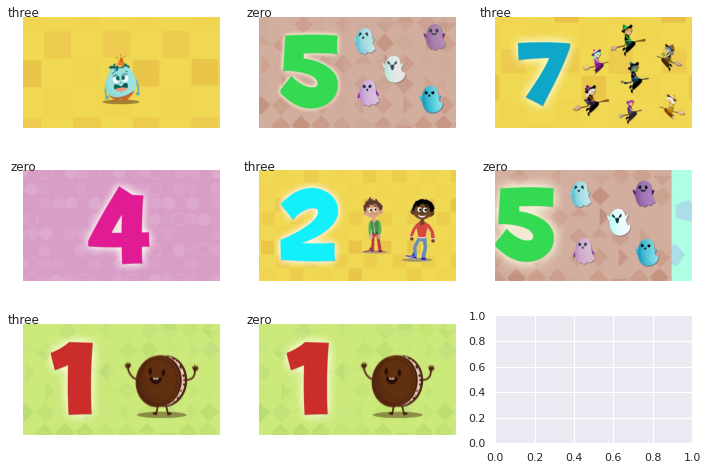

In [296]:
plot_multy(random_nums, frames)

#### Итоги

Модель работает плохо. Из видео выделяются фреймы с цифрами, но сами предсказания неверные. Это соотносится с тем, что точность модели на тренировке низкая.  

Требуется дополнительное исследование